In [ ]:
!pip install -qq transformers
!pip install -q -U watermark


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers
warnings.filterwarnings("ignore")

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.1+cu113
transformers: 4.23.1



In [ ]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'Uma frase para a cadeira de aprendizagem profunda'


In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Uma frase para a cadeira de aprendizagem profunda
   Tokens: ['Uma', 'frase', 'para', 'a', 'cadeira', 'de', 'aprendizagem', 'profunda']
Token IDs: [1431, 8422, 221, 123, 9104, 125, 11403, 6511]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=16,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

16


tensor([  101,  1431,  8422,   221,   123,  9104,   125, 11403,  6511,   102,
            0,     0,     0,     0,     0,     0])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Uma', 'frase', 'para', 'a', 'cadeira', 'de', 'aprendizagem', 'profunda', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
df = pd.read_csv("Dados_processadoPrincipal - Dados_processadoV3.csv")
df = df.dropna()
df = df.drop('Unnamed: 0', axis=1)
df = df.reset_index()

In [ ]:
df

,index,Nome,Twitter,Favor do candidato Lula,Favor do candidato Bolsonaro,Neutro
0,0,helo tavares,wilsonprattis eu tenho fe. eu acredito.lula\nd...,1,0,0
1,1,marco siqueira,sen_cristovam bora deixar essa discussao pra d...,1,0,0
2,2,leonardo lula silva,"cordeironereida bom dia. estou te seguindo, me...",1,0,0
3,3,ana,as mulheres;\na liberdade religiosa;\no lgbtqi...,1,0,0
4,4,claudio ou nene (meu apelido e nene mesmo),"mbendixens vote lula13 p manicure, empreendedo...",1,0,0
...,...,...,...,...,...,...
616,622,jaissontc,choquei se der um zoom na conta bancaria da ch...,0,0,1
617,623,cil77733322,"cristinagraeml , inumeros canais estao replica...",0,1,0
618,624,silas fiorotti,"""filha de bolsonaro [laurinha] entrara em cole...",0,0,1
619,625,fiorentino,priscillalleite aqui nao tem espaco para ladao...,0,1,0


In [ ]:
# 0 - Favor de Lula
# 1 - Neutro
# 2 - Favor de Bolsonaro

df["sentimento"] = np.zeros(df.shape[0])

for i in range(df.shape[0]):
  if df['Favor do candidato Lula'][i] == 1:
    df["sentimento"][i] = 0
  if df['Favor do candidato Bolsonaro'][i] == 1:
    df["sentimento"][i] = 2
  if df['Neutro'][i] == 1:
    df["sentimento"][i] = 1

In [ ]:
df = df.drop(["Favor do candidato Lula","Favor do candidato Bolsonaro","Neutro"], axis=1)

In [ ]:
df

,index,Nome,Twitter,sentimento
0,0,helo tavares,wilsonprattis eu tenho fe. eu acredito.lula\nd...,0.0
1,1,marco siqueira,sen_cristovam bora deixar essa discussao pra d...,0.0
2,2,leonardo lula silva,"cordeironereida bom dia. estou te seguindo, me...",0.0
3,3,ana,as mulheres;\na liberdade religiosa;\no lgbtqi...,0.0
4,4,claudio ou nene (meu apelido e nene mesmo),"mbendixens vote lula13 p manicure, empreendedo...",0.0
...,...,...,...,...
616,622,jaissontc,choquei se der um zoom na conta bancaria da ch...,1.0
617,623,cil77733322,"cristinagraeml , inumeros canais estao replica...",2.0
618,624,silas fiorotti,"""filha de bolsonaro [laurinha] entrara em cole...",1.0
619,625,fiorentino,priscillalleite aqui nao tem espaco para ladao...,2.0


In [ ]:
token_lens = []

for txt in df.Twitter:
  tokens = tokenizer.encode(str(txt), max_length=512)
  token_lens.append(len(tokens))

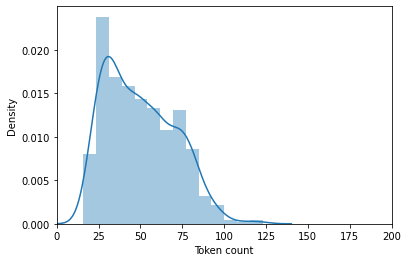

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 160
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape


((496, 4), (62, 4), (63, 4))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Twitter.to_numpy(),
    targets=df.sentimento.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
len(train_data_loader)


31

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class_names = ['Favor de Lula', 'Neutro', 'Favor de Bolsonaro']

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7591765138410753 accuracy 0.6330645161290323
Val   loss 0.33632767572999 accuracy 0.8870967741935484

Epoch 2/10
----------
Train loss 0.42168154122848667 accuracy 0.8508064516129032
Val   loss 0.23378240317106247 accuracy 0.9354838709677419

Epoch 3/10
----------
Train loss 0.2387208632163463 accuracy 0.9294354838709677
Val   loss 0.39284786442294717 accuracy 0.9193548387096774

Epoch 4/10
----------
Train loss 0.13995074450729356 accuracy 0.9637096774193548
Val   loss 0.45259765337686986 accuracy 0.9032258064516129

Epoch 5/10
----------
Train loss 0.08193011288981765 accuracy 0.9778225806451613
Val   loss 0.46342231816379353 accuracy 0.9354838709677419

Epoch 6/10
----------
Train loss 0.05829935713911489 accuracy 0.9858870967741935
Val   loss 0.5291077205911279 accuracy 0.9193548387096774

Epoch 7/10
----------
Train loss 0.028267954844200322 accuracy 0.9919354838709677
Val   loss 0.4752477420552168 accuracy 0.9354838709677419

Epoch 8/10
--------

In [ ]:
hist_train_acc = []
hist_val_acc = []

for i in history['train_acc']:
  hist_train_acc.append(i.item())

for j in history['val_acc']:
  hist_val_acc.append(j.item())

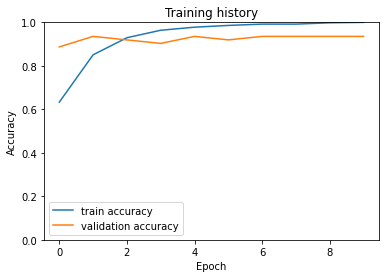

In [ ]:
plt.plot(hist_train_acc, label='train accuracy')
plt.plot(hist_val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

                    precision    recall  f1-score   support

     Favor de Lula       0.95      0.91      0.93        22
            Neutro       0.78      0.93      0.85        15
Favor de Bolsonaro       0.88      0.81      0.84        26

          accuracy                           0.87        63
         macro avg       0.87      0.88      0.87        63
      weighted avg       0.88      0.87      0.87        63



In [ ]:
print(628 * 0.2 * 0.5)

62.800000000000004


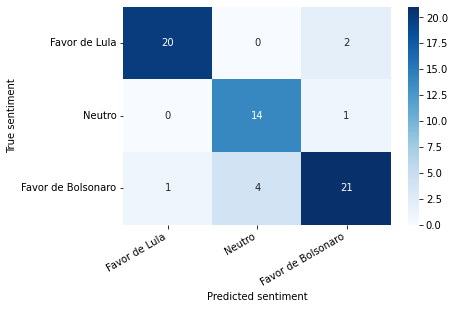

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 5

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

neymar ganhou pontos comigo, se mostrou um patriota, um brasileiro,
que se preocupa com os valores cristaos e com a familia, seguimos
juntos pra reeleger nosso presidente bolsonaro22

True sentiment: Favor de Bolsonaro


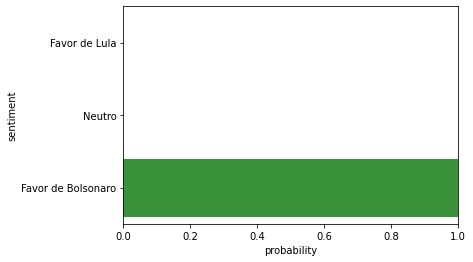

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
tests = ["Lula para presidente", 

        "vote 22 pelo bem do brasil!",
         
         "Na moral, todos os candidatos são pessimos.",

         "Lula é tao competente quanto bolsonaro",

         "Precisamos do fim da esquerda",

         "Bolsonaro é pessimo",

         "A esquerda destrui o Brasil, a salvação é #bolsonaro22"
         ]

In [ ]:
for test in tests:
  encoded_review = tokenizer.encode_plus(
    test,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  probs = F.softmax(output, dim=1)

  print(f'Review text: {test}')
  print(pd.DataFrame(probs.tolist()[0], class_names)[0])
  print("========================\n")

Review text: Lula para presidente
Favor de Lula         0.990285
Neutro                0.008259
Favor de Bolsonaro    0.001456
Name: 0, dtype: float64

Review text: vote 22 pelo bem do brasil!
Favor de Lula         0.000369
Neutro                0.000303
Favor de Bolsonaro    0.999328
Name: 0, dtype: float64

Review text: Na moral, todos os candidatos são pessimos.
Favor de Lula         0.000983
Neutro                0.998557
Favor de Bolsonaro    0.000460
Name: 0, dtype: float64

Review text: Lula é tao competente quanto bolsonaro
Favor de Lula         0.000503
Neutro                0.000888
Favor de Bolsonaro    0.998609
Name: 0, dtype: float64

Review text: Precisamos do fim da esquerda
Favor de Lula         0.994512
Neutro                0.004675
Favor de Bolsonaro    0.000813
Name: 0, dtype: float64

Review text: Bolsonaro é pessimo
Favor de Lula         0.734492
Neutro                0.263123
Favor de Bolsonaro    0.002386
Name: 0, dtype: float64

Review text: A esquerda destrui 